In [1]:
import numpy as np
import scipy.linalg as sl
import scipy.integrate as si
import scipy.optimize
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import time
import scipy.special as ss

In [2]:
# size of spatial domain
a = 10.0

# spatial grid for the purposes of plotting
xvec = np.linspace(-a, a, 1025)

# our Fourier representation will use basis functions from n = -nmax to n = nmax
nmax = 32
# convert basis coefficients into wavefunction on grid by matrix multiplication
nvec = np.arange(-nmax,nmax+1)
convmat = np.exp(1j * np.pi * np.outer(nvec, xvec) / a) / np.sqrt(2 * a)

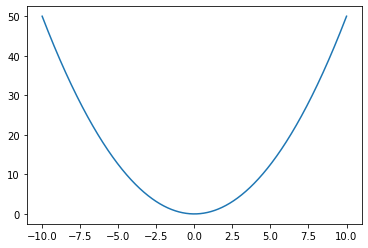

In [3]:
# harmonic oscillator
def v(x):
    # return 0.25*(x**2-25)**2
    return 0.5*x**2


plt.plot(xvec,v(xvec))
plt.show()


In [4]:
# some sampling and FFT tricks
# this integer '100' can be adjusted to improve resolution
# if we set f_sample = 2*nmax, then we are sampling at the Nyquist frequency
f_sample = 100 * 2 * nmax
t, dt = np.linspace(-a, a, f_sample+2, endpoint=False, retstep=True)
y = (np.fft.rfft(v(t)) / t.size)[:(2*nmax+1)]

# this stores the Fourier series coefficients for n-m=0 to n-m=2*nmax
vrow = y * (-1)**np.arange(2*nmax+1)

# if you want to use quadrature instead of the FFT:
vraw = np.zeros(2*nmax+1, dtype=np.complex128)
for thisn in range(2*nmax+1):
    def integ(x):
        return v(x) * np.exp(-1j * np.pi * thisn * x / a) / (2 * a)
    def rinteg(x):
        return np.real(integ(x))
    def iinteg(x):
        return np.imag(integ(x))
    vraw[thisn] = si.quad(rinteg, a=-a, b=a)[0] + 1j*si.quad(iinteg, a=-a, b=a)[0]

vrowquad = np.copy(vraw)


In [5]:
# THIS CELL IS ONLY MEANINGFUL IF v(x) is the SIMPLE HARMONIC OSCILLATOR

# for the harmonic oscillator, we can do the integral exactly (thanks, Mathematica!)
# here is the exact result
atr = a
ecfun = lambda j : (atr**2 * (2 * j * np.pi * np.cos(j * np.pi) + (-2 + j**2 * np.pi**2) * np.sin(j*np.pi))) / (2.0 * j**3 * np.pi**3)
exactvrow = np.array(list(map(ecfun, np.arange(1,2*nmax+1))))
exactvrow = np.concatenate([np.array([atr**2 / 6.0]), exactvrow])

# let us check which one is more accurate, FFT or quadrature
print(np.linalg.norm(vrow - exactvrow))
print(np.linalg.norm(vrowquad - exactvrow))

# we see that vrowquad is more accurate so we use that!

6.557417998345006e-06
6.477425597786634e-14


In [6]:
# kinetic matrix
kmat = np.diag(np.arange(-nmax, nmax + 1)**2 * np.pi**2 / (2 * a**2) )

# use vrowquad to create Toeplitz matrix
vmat = sl.toeplitz(r=vrowquad,c=np.conj(vrowquad))

# Hamiltonian matrix 
hmat = kmat + vmat

# check whether Hamiltonian is Hermitian
print(np.linalg.norm(hmat - np.conj(hmat.T)))

# eigendecomposition
spec, states = np.linalg.eigh(hmat)

# check whether this diagonalizes hmat
# note that if this is close to zero it means that
# hmat = states @ np.diag(spec) @ np.conj(states).T
print(np.linalg.norm(hmat @ states - states @ np.diag(spec)))

# check whether we have a unitary matrix
print(np.linalg.norm(states @ np.conj(states).T - np.eye(2 * nmax + 1)))

0.0
3.160930230331545e-13
1.182673699250653e-14


[0.5 1.5 2.5 3.5 4.5 5.5]


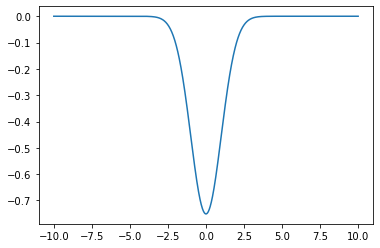

1.0000000000000002
Check of Ground state' normalization (should be close to 1):
1.0000000000000002


In [8]:
# find indices that sort eigenvalues
ordering = np.argsort(spec)

# print first few eigenvalues
print(spec[ordering[:6]])

# pick out and plot ground state
groundstate = ordering[0]
wavefn = states[:,groundstate] @ convmat
plt.plot(xvec, np.real(wavefn))
plt.show()

# check normalization
print(np.sum(np.abs(wavefn)**2 * (xvec[1]-xvec[0])))

# this should be a more accurate check of the ground state
# wave functions' normalization
print('Check Ground state\' normalization (should be close to 1):', si.trapezoid(np.abs(wavefn)**2, xvec), sep='\n')

In [9]:
# let us now represent V(x) using Chebyshev polynomial
# this should be exact because V(x) **is** a polynomial

[ 2.50000000e+01  4.73695157e-15  2.50000000e+01  3.55271368e-15
 -9.47390314e-15  2.13162821e-14 -4.73695157e-15  1.42108547e-14
 -1.06581410e-14  1.65793305e-14 -3.43428989e-14  2.19084010e-14]


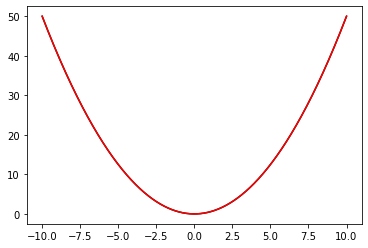

1.4921397450962104e-13


In [16]:
n = 11

def theta(k):
    return (k - 0.5) * np.pi / (n + 1)

def g(k):
    return v(a * np.cos(theta(k)))

kvec = np.arange(1, n + 2)
cnvec = np.arange(0, n + 1)

weights = np.ones(n+1)
weights[0] = 0.5

# compute Chebyshev coefficients
cvec = 2 / (n + 1) * np.sum(g(kvec) * np.cos(cnvec[..., np.newaxis] * theta(kvec)), axis=1)
cvec = weights * cvec
print(cvec)

# reconstruct on plotting grid
vrecon = ss.eval_chebyt(np.expand_dims(cnvec,0), np.expand_dims(xvec/a,1)) @ cvec
    
# plot both
plt.plot(xvec, v(xvec), color='black')
plt.plot(xvec, vrecon, color='red')
plt.show()

# Linfty norm error
print(np.max(np.abs(v(xvec) - vrecon)))

In [21]:
# we now want to take our Chebyshev-represented potential,
# and use it to form the entries of vmat
# let us do this with quadrature

# first let's define a function that returns the chebyshev approximant
def vcheb(x):
    return ss.eval_chebyt(np.expand_dims(cnvec, 0), x / a) @ cvec

vchebraw = np.zeros(2*nmax+1, dtype=np.complex128)
for thisn in range(2*nmax+1):
    def integ(x):
        return vcheb(x) * np.exp(-1j * np.pi * thisn * x / a) / (2 * a)
    def rinteg(x):
        return np.real(integ(x))
    def iinteg(x):
        return np.imag(integ(x))
    vchebraw[thisn] = si.quad(rinteg, a=-a, b=a)[0] + 1j*si.quad(iinteg, a=-a, b=a)[0]

vchebrowquad = np.copy(vchebraw)

In [22]:
# how much does this differ from our old vrowquad?
print(np.linalg.norm(vrowquad - vchebrowquad))
print('L-infinity Error:', np.max(np.abs(vrowquad - vchebrowquad)))

3.323854363582271e-14
L-infinity Error: 1.2101348630776924e-14


In [23]:
# use vchebrowquad to create Toeplitz matrix
vchebmat = sl.toeplitz(r=vchebrowquad, c=np.conj(vchebrowquad))

# Hamiltonian matrix 
hchebmat = kmat + vchebmat

# check whether Hamiltonian is Hermitian
print(np.linalg.norm(hchebmat - np.conj(hchebmat.T)))

# eigendecomposition
chebspec, chebstates = np.linalg.eigh(hchebmat)

# check whether this diagonalizes hmat
# note that if this is close to zero it means that
# hmat = states @ np.diag(spec) @ np.conj(states).T
print(np.linalg.norm(hchebmat @ chebstates - chebstates @ np.diag(chebspec)))

# check whether we have a unitary matrix
print(np.linalg.norm(chebstates @ np.conj(chebstates).T - np.eye(2*nmax+1) ))

0.0
4.2231608591843004e-13
1.2631304321995936e-14


1.0


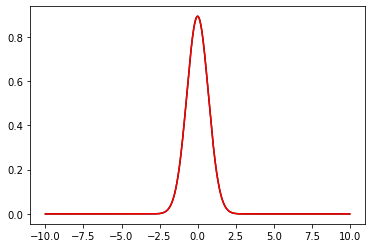

7.817074419108515e-12
L-infinity Error: 4.177769241664464e-13


In [25]:
# a super simple initial condition, a Gaussian with L^2 norm = 1
def psi0(x):
    return np.exp(-x**2) * (2.0/np.pi)**0.25

def psi0squared(x):
    return psi0(x)**2

print(si.quad(psi0squared, a=-a, b=a)[0])

vraw = np.zeros(nmax+1, dtype=np.complex128)
for thisn in range(nmax+1):
    def integ(x):
        return np.exp(-1j * np.pi * thisn * x / a) * psi0(x) / np.sqrt(2 * a)
    def rinteg(x):
        return np.real(integ(x))
    def iinteg(x):
        return np.imag(integ(x))
    vraw[thisn] = si.quad(rinteg, a=-a, b=a)[0] + 1j*si.quad(iinteg, a=-a, b=a)[0]

ainit = np.concatenate([np.conjugate(np.flipud(vraw[1:])), vraw])

# just check whether psi0 is represented OK
plt.plot(xvec, psi0(xvec), color='black')
psi0recon = np.real(ainit @ convmat)
plt.plot(xvec, psi0recon, color='red')
plt.show()

print(np.linalg.norm(psi0(xvec) - psi0recon))
print('L-infinity Error:', np.max(np.abs(psi0(xvec) - psi0recon)))

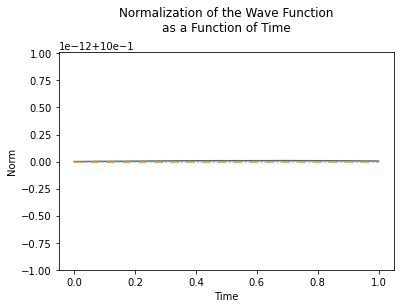

Average Norm of Trajectory (should be close to 1):
1.0000000000000056


In [27]:
# PROPAGATE WITH ACTUAL v(x)

# set the time step and compute the propagator matrix
# note that we are reusing the spec, states eigendecomposition of hmat computed above
dt = 1e-2

# propagate the "a" vector of coefficients as defined above
nsteps = 100

prop = states @ np.diag(np.exp(-1j*spec*dt)) @ np.conj(states.T)

amat = np.zeros((nsteps+1, 2*nmax+1), dtype=np.complex128)
amat[0,:] = np.copy(ainit)
for j in range(nsteps):
    amat[j+1,:] = prop @ amat[j,:]

# compute the wave function in space from each "a" vector
# do it all at once using matrix multiplication!
psi = amat @ convmat

# check if the wave function of each time step
# is normalized to 1
# this should produce a graph with a line that is almost
# completely horizontal at 1
psinormvec = si.trapezoid(np.abs(psi) ** 2, xvec, axis=1)
plt.plot(np.arange(nsteps + 1) * dt, psinormvec)
plt.hlines(1 , 0, nsteps * dt, linestyles='-.', colors='darkorange')
plt.title('Normalization of the Wave Function\nas a Function of Time\n')
plt.xlabel('Time')
plt.ylabel('Norm')
plt.show()

# norm difference of wave function normalization check,
# this should be close to 1
print('Average Norm of Trajectory (should be close to 1):', psinormvec.sum() / (nsteps + 1), sep='\n')

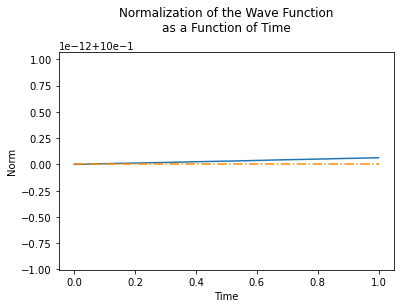

Average Norm of Trajectory (should be close to 1):
1.0000000000000313


In [28]:
# PROPAGATE WITH CHEB v(x)

# set the time step and compute the propagator matrix
# note that we are reusing the spec, states eigendecomposition of hmat computed above
dt = 1e-2
chebprop = chebstates @ np.diag(np.exp(-1j*chebspec*dt)) @ np.conj(chebstates.T)

# propagate the "a" vector of coefficients as defined above
nsteps = 100
cmat = np.zeros((nsteps+1, 2*nmax+1), dtype=np.complex128)
cmat[0,:] = np.copy(ainit)
for j in range(nsteps):
    cmat[j+1,:] = chebprop @ cmat[j,:]

# compute the wave function in space from each "a" vector
# do it all at once using matrix multiplication!
chebpsi = cmat @ convmat

# check if the wave function of each time step
# is normalized to 1
# this should produce a graph with a line that is almost
# completely horizontal at 1
chebpsinormvec = si.trapezoid(np.abs(chebpsi) ** 2, xvec, axis=1)
plt.plot(np.arange(nsteps + 1) * dt, chebpsinormvec)
plt.hlines(1 , 0, nsteps * dt, linestyles='-.', colors='darkorange')
plt.title('Normalization of the Wave Function\nas a Function of Time\n')
plt.xlabel('Time')
plt.ylabel('Norm')
plt.show()

# norm difference of wave function normalization check,
# this should be close to 1
print('Average Norm of Trajectory (should be close to 1):', chebpsinormvec.sum() / (nsteps + 1), sep='\n')

3.4195526931642435e-12


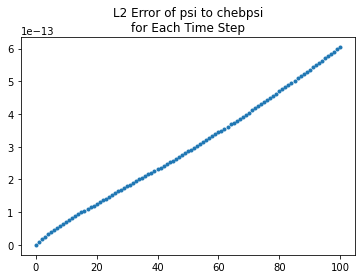

In [33]:
print(np.linalg.norm(psi - chebpsi))

plt.plot(np.linalg.norm(psi - chebpsi, axis=1), '.')
plt.title('L2 Error of psi to chebpsi\nfor Each Time Step')
plt.show()
